##### <font color="C13F38"><strong>This homework is due at midnight on April 21, 2023. </strong></font>

Run the cell below to get started.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import lognorm

def lognfit(data):
    # Compute the mean and standard deviation of the natural logarithm of the data
    mu = np.mean(np.log(data))
    sigma = np.std(np.log(data))

    return mu, sigma

def lognrnd(mu, sigma, size=1000):
    # Generate random samples from a lognormal distribution
    # default size is 1000
    return lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=size)


There are 35 points to earn in this second section.

# Using the drift diffusion model to explain economic choice

As you have seen so far, simulations from the drift diffusion model provide a rich set of results from a relatively small set of assumptions. But, the decisions we have talked about so far have been extremely simple. In essence, they share a lot of similarity with Franciscus Donders earliest psychology experiments: instead of deciding on which side a light goes on, participants in the dot motion coherence task are simply determining in which direction dots are moving.

However, most of the choices we make in everyday life are not so straightforward! As we touched upon during the reinforcement learning lectures, a lot of our decisions are based on the subjective values we attach to each choice option. So, the natural question is whether the drift diffusion model is able to account for RTs when making value-based choices.

Of course, we wouldn’t be talking about this if the answer to this question was ‘no’. It turns out that we can extend the drift diffusion relatively easily to account for value-based choice. Here, we are going to do this for the simplest choice, namely one between two options. Let’s assume
that we have learned a value $r$, an expected reward, for each of these options. We will denote these values by $r_1$ and $r_2$. Now, the only thing we need to do is to assume that, in order to make a choice between the two options, people accumulate (noisy) evidence about the difference between their expected rewards ($r_1-r_2$).

So, in the equation for the drift diffusion model that we depicted above, we can replace the evidence term (before: the strength of the evidence for dots moving left or right) with this difference in rewards. This gives us the following:

$V_{t+1} = V_t + d \cdot (r_1 - r_2) + \epsilon_t$,

with the parameters $d$ and $\epsilon$ the same as defined above. Now, if we set some positive threshold $A$ and a negative threshold $-A$, so that when $V>A$ the agent chooses option 1, and when $V< -A$ the agent chooses option 2.

## 1. A role for attention during evidence accumulation

So far, so good! According to this framework, the only thing that is necessary to understand how long it takes to choose between options, is the number of timesteps it takes for the drift diffusion process to resolve itself (plus the non-decision time $\tau$). According to a study by Ian Krajbich and colleagues (2010), this is almost exactly right.

They asked their participants to not eat for several hours, and then brought them in the lab. There, they first rated a bunch of food items on a scale from 0 to 10. Next, a choice phase followed. On each trial, one food item was presented on the left, and the other on the right. Participants were given ample time to decide between the two options. In addition to recording participants’ choices, and how long it took them to reach their decision, they also used an eye tracker in order to measure where on the screen people were looking while making a decision. In other words, for each trial they determined, from moment-to-moment, which of the two food options the participants were attending to, and how long it took for them to switch to the other.

They did so, because they believed that decision making isn’t just a process in which the values of two items are compared against each other with the goal to maximize reward. Their intuition was that this process is more complicated, and that attention must play a role. In the words of the authors, consider “a typical buyer at the grocery store choosing between two snacks”. “Instead of approaching the shelf and immediately selecting his preferred option, the individual’s gaze shifts repeatedly between the items until one of them is eventually selected.”

So, the hypothesis is that attention to one choice option over the other in some way affects the drift diffusion process. Intuitively, this makes sense (at least to me). If you want to figure out how valuable a certain choice option is, paying attention to it might allow you to deliberate on the differing characteristics that make that option good. For example, having to choose between a bag of potato chips and an apple, you might first pay attention to the chips and realize that they will be crispy, salty, and have that fatty quality that we like in food. Attending to these features might make you more likely to pick the chips. However, if you then were to pay attention to the apple, and realize how fresh, snappy, and healthy it would be, you might be swayed to prefer the apple over the chips.

Note that this process of deliberation over multiple options is fully possible without participants actually looking directly at the choice options. However, Krajbich and colleagues (2010) reasoned that they would be able to at least infer some aspect of the attention paid to one choice option over the other by measuring on which item people would focus at each moment in time.

## 2. The attentional drift diffusion model


Let’s first explore how Krajbich and colleagues adapted the drift diffusion model to be able to account for a modulation of the process by attention. The key difference between their “attentional” drift diffusion model and the standard model is that the slope with which $V$ evolves over time depends on the fixation location. In particular, this slope is proportional to a _weighted_ difference between values of the fixated an unfixated items. They did so by introducing a parameter $\theta$ (bounded between 0 and 1), which determines to which degree the unfixated item’s value gets discounted during the evidence accumulation process. Specifically, the reward values
of the left and right options are now given as $r_{left}$ and $r_{right}$. So, if the participant is looking to the left item, the decision variable $V$ changes according to

$V_{t+1} = V_t + d \cdot (r_{left} - \theta \cdot r_{right}) + \epsilon_t$,

and when the participant is looking to the right item, $V$ changes according to

$V_{t+1} = V_t + d \cdot (\theta \cdot r_{left} -  r_{right}) + \epsilon_t$.

Here, the parameters $d$ and $\epsilon$ are as defined above.


We have almost enough information to implement the attentional drift diffusion model, but there is one thing that we do not know: how to model fixation durations. Luckily, Ian Krajbich shared his data with me, and so I have all the fixation durations that happened during the experiment. You can have a look at them as well! They are stored in the variable `fixation_durations.npy` file. Here is a histogram of the fixation for all trials that happened during the experiment:

(array([4.370e+02, 5.760e+02, 1.083e+03, 1.265e+03, 1.517e+03, 1.391e+03,
        1.341e+03, 9.590e+02, 7.510e+02, 4.940e+02, 4.430e+02, 3.400e+02,
        2.520e+02, 2.010e+02, 1.490e+02, 1.380e+02, 1.110e+02, 8.300e+01,
        6.300e+01, 6.300e+01, 6.300e+01, 5.500e+01, 4.200e+01, 4.400e+01,
        2.300e+01, 2.700e+01, 1.600e+01, 1.900e+01, 1.700e+01, 2.400e+01,
        1.400e+01, 1.200e+01, 1.300e+01, 1.200e+01, 1.800e+01, 1.000e+01,
        1.100e+01, 1.200e+01, 6.000e+00, 1.000e+00, 6.000e+00, 7.000e+00,
        5.000e+00, 6.000e+00, 4.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+0

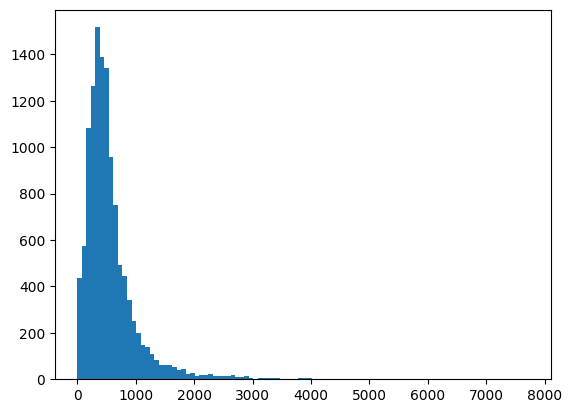

In [2]:
# load in fixation data
fixations = np.load('data/fixation_durations.npy')

plt.hist(fixations[:], bins=100)

According to Krajbich and colleagues, the fixation durations were relatively unaffected by the value of the items on the screen. They found that participants did not seem to preferentially fixate on the item with the higher value at the start of the trial, and that this trend continued for the fixations that occurred in the middle of the trial. They only found that the durations of the fixations in the middle of the trial depended on the difference in value between the fixated and the nonfixated items. However, this effect was minimal, and so, to make things easier for us, we are going to assume that fixation durations are _independent_ of the values of items.

Apparently, the distribution of fixation durations is best described by a log-normal distribution. We haven’t seen log-normal distributions in this class yet, but it’s a concept that is not hard to grasp with everything that we have seen: it is just the natural log transformation of the normal distribution. So, in order to simulate behavior on the task, we need to find the parameter values of the log-normal distribution that best describes the data. Luckily, python makes fitting data to this distribution using maximum likelihood estimation _extremely_ easy:


In [3]:
# logrnd example
mu, sigma = lognfit(fixations)
print(mu, sigma)

6.0697117 0.79045486


Great! So, the log-mean of the distribution is 6.0697, and the log-standard deviation is 0.7905. Now, generate some random data with this function, and inspect whether the shape of this distribution is reasonably close to the actual fixation durations.

(array([ 43.,  80., 111., 113.,  88.,  91.,  61.,  67.,  56.,  39.,  37.,
         33.,  18.,  27.,  13.,  10.,  14.,  11.,   9.,   7.,   7.,   4.,
          6.,  13.,   3.,   1.,   3.,   4.,   2.,   3.,   3.,   2.,   1.,
          0.,   1.,   1.,   1.,   0.,   2.,   1.,   1.,   0.,   0.,   2.,
          2.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  41.66960538,  108.64891271,  175.62822003,  242.60752736,
         309.58683469,  376.56614202,  443.54544934,  510.52475667,
         577.504064  ,  644.48337133,  711.46267865,  778.44198598,
         845.42129331,  912.40060064,  979.37990796, 1046.35921529,
        1113.33852262, 1180.31782995, 1247.297

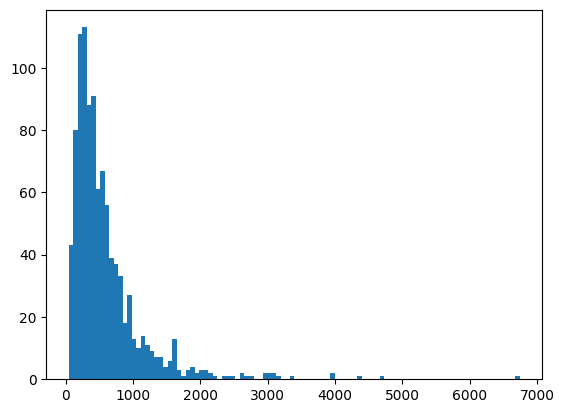

In [4]:
# generate 1000 random numbers from the lognormal distribution
log_rnd = lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=1000)
plt.hist(log_rnd,bins=100)

Now that we know how the attentional drift diffusion model works, and how we can simulate durations for the fixations (i.e., by drawing random numbers from the log-normal distribution with the above parameter values), we have enough information to start implementing the attentional drift diffusion model.

## 3. Implementing the attentional drift diffusion model

<font color="508C46"><strong>Question 1 (8 points)</strong> <br>
Adapt the function from Question 1 in the first part in order to implement the attentional drift diffusion model. Note that the function that will now also take both the attention parameter $\theta$ and the reward values ($r_{left}$ and $r_{right}$) as input, and that the reward values replace the evidence value in the previous code. In addition to this, you need to determine which side (left or right) is attended to _and for how long_. If a current fixation is finished, the attention should switch to the other side, and a new fixation duration should be drawn. Assume that each cycle of the drift diffusion model corresponds to 1ms, and use `lognrnd` to determine each fixation’s duration. Make sure that you save not only the duration of each fixation (including the last one), but also to which side each fixation was oriented in the `trial` dictionary.
</u></b></font>

In [5]:
def ddm_values_trial(theta, driftRate, noise_SD, thresholds, tau, rLeft, rRight):# add correct arguments
    negA = thresholds[0]
    posA = thresholds[1]
    V = [0]
    vList = []
    durationList = []
    whichSide = []
    trial = {} #rt, choice, v[], accuracy (0 or 1)
    rt = 0
    t = 0
    dur_t=0
    left = True
    duration = lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=1)    

    while abs(V[0]) < posA: 
      noise = np.random.normal(0,noise_SD)
      
      if left: #left
        V[0] = V[0] + driftRate * (rLeft - theta*rRight) + noise # make sure that V contains all values of the decision variable over time
        if dur_t>=duration: #left
          left = False
          durationList.append(float(duration))
          whichSide.append("Left")
          duration = lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=1)
          dur_t = 0
      else: #right
        V[0] = V[0] + driftRate * (theta*rLeft - rRight) + noise 
        if dur_t>=duration:
          durationList.append(float(duration))
          whichSide.append("Right")
          left = True
          duration = lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=1)
          dur_t = 0
      vList.append(V[0])
      rt = t + tau
      t += 1
      dur_t +=1
      
    if V[0] > 0:
      choice = 1
    else:
      choice = -1
    if choice * (rLeft-rRight) > 0:
      accuracy = 1
    else:
      accuracy = 0

    trial = {'rt': rt,'V': vList,'choice': choice, 'accuracy': accuracy, 'duration': durationList, 'whichSide': whichSide } # save the rest of the results in the dictionary 
    return trial

<font color="508C46"><strong>Question 2 (3 points)</strong> <br>
In order to test your function, find two different trials with $\theta=0.6$, $d = 0.0005$, $\sigma = 0.01$ that have at least three switches in fixation (just for proper visualization). For one trial, set $r_{left} = r_{right} = 7$ and for the other set $r_{left} = 5$ and $r_{right} = 8$ (just like in the Krajbich paper). <u>**Show how $V$ develops over time for these two trials. (Use `plt.axvline` to plot vertical lines at the time points where the attention switched.) Explain what you see. For the first trial, which factors determine whether $V$ goes up or down? For the second trial, which factors determine whether $V$ goes up or down?**</u>
</b></font>

['Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left', 'Right', 'Left']
[208.35976013177765, 777.5214503871332, 204.31038995829226, 260.27472773912126, 242.09573889862375, 1070.5448914496599, 121.06161432501787, 180.05108505580688, 275.06719248191195, 1299.784246246185, 841.8234576219194, 408.8098441501571, 316.8563401280295, 463.34566256413405, 651.1707190163905]


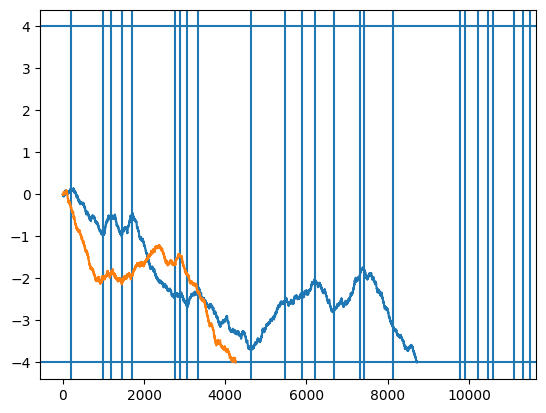

In [14]:
# your code here
res = ddm_values_trial(0.6, 0.0005, 0.01, [-4,4], 50, 7, 7)
print(res['whichSide'])
print(res['duration'])
t = 0
plt.plot(res['V'])
for i in range(0, len(res['duration'])):
  t = t + res['duration'][i]
  plt.axvline(x=t)
plt.axhline(y = 4)
plt.axhline(y = -4)

res2=ddm_values_trial(0.6, 0.0005, 0.01, [-4,4], 50, 5, 8)
plt.plot(res2['V'])
for i in range(0, len(res2['duration'])):
  t = t + res2['duration'][i]
  plt.axvline(x=t)


.. double click this to type your response.

In the first graph, we see that when the reward values are the same for either option, it takes longer for the graph to converge to the threshold (for the decision to be made) than when one option has a higher value than another. We also see that reward value does not implicate where the graph starts. V tends to switch directions when fixation switches (this is clearly shown in the second trial).

<font color="508C46"><strong>Question 3 (3 points)</strong> <br>
Repeat the simulations from Question 1 with $r_{left} = 5$ and $r_{right} = 8$ three times, first by setting $\theta = 0$, then $\theta = 0.6$ and finally $\theta = 1$. <u>**What do you see? Show us. For each of these settings**</u>($\theta = 0$, $\theta = 0.6$, $\theta = 1$)<u>**, consider what role attention plays and relate this to the evolution of $V$ over time.**

</u></b></font>

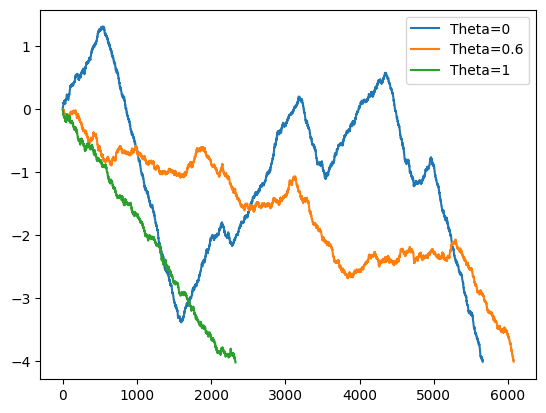

In [15]:
# your code here
res_low_theta = ddm_values_trial(0, 0.0005, 0.01, [-4,4], 50, 5, 8) 
res_mid_theta = ddm_values_trial(0.6, 0.0005, 0.01, [-4,4], 50, 5, 8)
res_high_theta = ddm_values_trial(1, 0.0005, 0.01, [-4,4], 50, 5, 8)
plt.plot(res_low_theta['V'], label='Theta=0')
plt.plot(res_mid_theta['V'], label='Theta=0.6')
plt.plot(res_high_theta['V'], label='Theta=1')
plt.legend()


.. double click this to type your response.

When theta=0 , meaning that the item not fixated on does not get discounted, V is much more volatile and takes longer to converge. On the other hand, when theta=1 and the item not attended to gets discounted the most, the model is quick to arrive to a choice. This clearly shows that attention is involved in decison making 

## 3. Why do we need an attentional drift diffusion model?

By now, you might be wondering why we are going through all this effort to draw up an attentional drift diffusion model. It may _sound_ like a plausible way in which attention gates the accumulation of value during decision making, but we have no real evidence that we need to think about it this way. In fact, I quoted the introduction of the author’s Nature Neuroscience paper earlier in this section, in which they simply invoke the image of someone switching their attention between two snacks at grocery store. So, do we really need an attention in our drift diffusion models?

If you ask Krajbich and colleagues (2010), they would respond with a resounding ‘yes’. Why? Well, they would respond by saying that they found that (1) the final fixations between items were significantly shorter than all other fixations and (2) that participants generally chose the item they looked at last.

<font color="508C46"><strong>Question 4 (2 points)</strong> <br>
<u>**From a conceptual standpoint, why do you think that the attentional model makes these predictions? Why does the ‘regular’ drift diffusion model not account for these effects?**

</u></b></font>


.. double click this to type your response.

the attentional model predicts that final fixations are shorter than all others because fixation duration contributes to evidence formation (as a function of reward and theta). Over time, more evidence has been collected and there is less need to fixate. Furthermore, the recency effect may explain why participants chose the item they looked at last. The regular ddm does not have these extra parameters related to attention and thus does not take into account the role fixation plays in making decisions 

In the remainder of this lab, you are going to test whether the attentional drift diffusion model actually makes these predictions as well.

To do so, you are first going to write a function that lets you generate multiple trials of the attentional drift diffusion model (just like in Questions 3 and 6). Of course, to do so, we need trials with varying values of the items and left and right. One way to do this would be to simply draw random (round) numbers between 0 and 10 for both sides. You can also use the variable values in `values.npy`, which are all the actual ratings that participants in the Krajbich studies provided, and _simply draw a new random row from this matrix on each trial._

<font color="508C46"><strong>Question 5 (4 points)</strong> <br>
Write a new function that lets you generate multiple trials of the attentional drift diffusion model (mirroring the previous questions of this format), with random reward values for the left and right side on each trial. In the next two questions, you will use this code to test the two predictions above, so for each trial you want to save enough information to do so.
</u></b></font>

In [9]:
vals = np.load('data/values.npy')
len(vals)

3791

In [10]:
# your code here
def ddm_simulate_attn(theta, driftRate, noise_SD, thresholds, tau, nrtrials):# add correct arguments
  durations = []
  choice = []
  lastSide = []
  finalDurations = []
  for n in range(0, nrtrials):
     rLeft = np.random.rand()
     rRight = np.random.rand()
     trial = ddm_values_trial(theta, driftRate, noise_SD, thresholds, tau, rLeft, rRight)
     durations.append(trial['duration'])
     choice.append(trial['choice'])
     lastSide.append(trial['whichSide'][-1])
     finalDurations.append(trial['duration'][-1])
  return durations, choice, lastSide, finalDurations

For the next two questions we are going to use the parameter values that Krajbich and colleagues (2010) found to be the best fit to their data. Their maximum likelihood estimation model fitting procedure was quite involved (it uses a form of grid search based on simulations of the model), so we will not replicate it here. Their best fitting values for the attentional drift diffusion model were $\theta = 0.3$, $d = 0.0002$ and $\sigma = 0.02$.

<font color="508C46"><strong>Question 6 (5 points)</strong> <br>
<u>**Use these two functions (and the parameter values described above) to show that the final fixation of each trial is, on average, shorter than the middle.**</u> You may need to edit the function from Question 1 to accommodate some additional data. Note that it’s not necessary (or advisable) to use inferential statistics on these analyses, since there is no independence between the data points (they all come from the same agent). **<u>Simply run a lot of trials (say, 1000), and then compare the distribution of durations of the final fixations, against those of all other durations. Show us your results and interpret them. Show us your work.**</u> Hint: Looking the distributions, consider whether the mean or the median is a better way to describe the data. Also, it might be useful to know that `np.nanmean/np.nanmedian` exist.
</u></b></font>

Text(0.5, 0, 'Final fixation times')

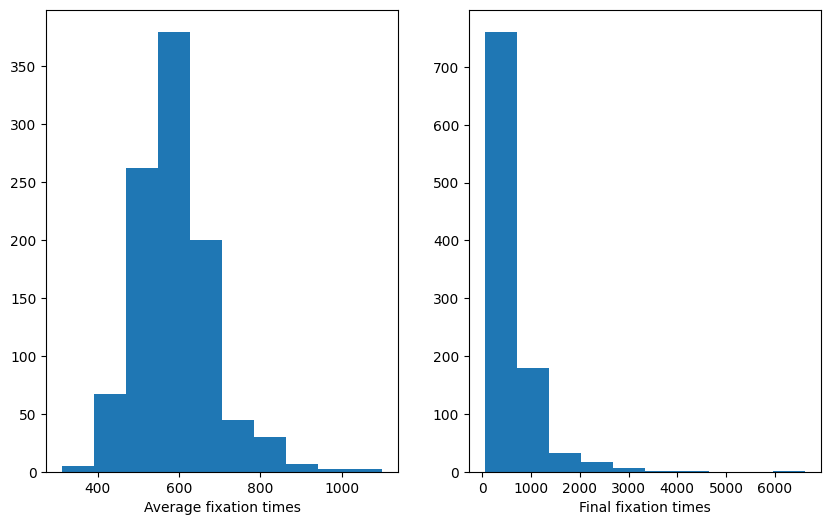

In [17]:
# your code here
durations, choices, lastSide, finalDurations = ddm_simulate_attn(0.3, 0.0002, 0.02, [-4,4], 50, 1000) 
dur = np.zeros(len(durations))
final = np.zeros(len(durations))
for n in range(0,len(durations)):
  dur[n] = np.average(durations[n])
  final[n] = finalDurations[n]
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].hist(dur)
ax[0].set_xlabel('Average fixation times')
ax[1].hist(final)
ax[1].set_xlabel('Final fixation times')

In [18]:
print(np.median(final))
print(np.median(dur))

433.1075440245277
579.2629297694134



.. double click this to type your response.

Both from the graphs and from the printed median values, we see that final fixation times are shorter than middle fixation times. Because of the large sample size, there are certainly outliers but most of the data supports this

<font color="508C46"><strong>Question 7 (5 points)</strong> <br>
Now, use the functions to test whether the agent is more likely to choose the last item it fixated on than the other item. <u>**On what proportion of trials does the model select the item it fixated on last? If it does, why does it not always select that item?**</u></b></font>

In [25]:
# your code here
durations, choices, lastSide, finalDuration = ddm_simulate_attn(0.3, 0.0002, 0.02, [-4,4], 50, 100)
count=0
for i in range(100):
  if lastSide[i]=='Left':
    lastSide[i]=-1
  else:
    lastSide[i]=1
  if lastSide[i]==choices[i]:
    count=count+1
print(count/100)


0.63



.. double click this to type your response.

Around 63% of final fixations match the choice that was made. The agent is more likely to do this, but not by much. This is because of the variation in fixation duration times and the variability in number of fixations within each trial. 

<font color="508C46"><strong>Question 8 (5 points)</strong> <br>
Use these same functions to investigate whether the key characteristic of this model, the weighting of reward values by attention, is crucial to get these two effects. <u>**What did you do achieve this? What are your findings? Show us.**</u></b></font>

In [26]:
# your code here
# small, medium, large theta 
durations_small, choices_small, lastSide_small, finalDuration_small = ddm_simulate_attn(0.001, 0.0002, 0.02, [-4,4], 50, 100)
durations_med, choices_med, lastSide_med, finalDuration_med = ddm_simulate_attn(0.5, 0.0002, 0.02, [-4,4], 50, 100)
durations_big, choices_big, lastSide_big, finalDuration_big = ddm_simulate_attn(0.99, 0.0002, 0.02, [-4,4], 50, 100)
# proportion final= choice / total 

count_small =0
for i in range(100):
  if lastSide_small[i]=='Left':
    lastSide_small[i]=-1
  else:
    lastSide_small[i]=1
  if lastSide_small[i]==choices_small[i]:
    count_small=count_small+1
print(count_small/100)

count_med =0
for i in range(100):
  if lastSide_med[i]=='Left':
    lastSide_med[i]=-1
  else:
    lastSide_med[i]=1
  if lastSide_med[i]==choices_med[i]:
    count_med=count_med+1
print(count_small/100)

count_big =0
for i in range(100):
  if lastSide_big[i]=='Left':
    lastSide_big[i]=-1
  else:
    lastSide_big[i]=1
  if lastSide_big[i]==choices_big[i]:
    count_big=count_big+1
print(count_big/100)

#finalfixation times smaller

dur_small = np.zeros(len(durations_small))
final_small = np.zeros(len(durations_small))
for n in range(0,len(durations_small)):
  dur_small[n] = np.average(durations_small[n])
  final_small[n] = finalDuration_small[n]



dur_med = np.zeros(len(durations_med))
final_med = np.zeros(len(durations_med))
for n in range(0,len(durations_med)):
  dur_med[n] = np.average(durations_med[n])
  final_med[n] = finalDuration_med[n]

dur_big = np.zeros(len(durations_big))
final_big = np.zeros(len(durations_big))
for n in range(0,len(durations_big)):
  dur_big[n] = np.average(durations_big[n])
  final_big[n] = finalDuration_big[n]
print("comparing median fixation times in the middle and end of trials for small theta")
print(np.median(final_small))
print(np.median(dur_small))

print("comparing median fixation times in the middle and end of trials for medium theta")

print(np.median(final_med))
print(np.median(dur_med))

print("comparing median fixation times in the middle and end of trials for large theta")
print(np.median(final_big))
print(np.median(dur_big))

0.71
0.71
0.49
comparing median fixation times in the middle and end of trials for small theta
483.2863847726312
579.1998038458605
comparing median fixation times in the middle and end of trials for medium theta
461.5145730779516
586.186871780123
comparing median fixation times in the middle and end of trials for large theta
475.6972815221482
582.0467813904568



.. double click this to type your response.

For smaller theta, the proportion of times the choice corresponds with the item last fixated on is much higher than for largert thetas. Across all values of theta, final fixation duration is smaller than fixtion times in the middle


Great! We used a method typically used to model reaction times, to show that when we include attention we are able to simulate choice biases that happen in actual behavior! I think that’s pretty cool, and I hope you found it enjoyable as well. The paper published by Krajbich and colleagues (2010) goes in a lot more detail about the model than we have been able to, so I hope you find it a good read.